###**Librerias**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install vitaldb
import vitaldb
!pip install neurokit2
import neurokit2 as nk

In [ ]:
plt.style.use('seaborn-whitegrid')
#%matplotlib qt
plt.close('all')

<ipython-input-11-243ac5600bca>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


###**Cargando información de VitalDB**

In [ ]:
df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # clinical information
df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # track list

###**Criterios de inclusión/exclusión**

In [ ]:
# Con este filtro se obtienen los id de los pacientes que cumplen con las condiciones mencionadas
caseids = list(
    set(df_trks.loc[df_trks['tname'] == 'SNUADC/ECG_II','caseid']) &
    set(df_trks.loc[df_trks['tname'] == 'BIS/BIS','caseid']) &
    set(df_cases.loc[df_cases['department'] == 'General surgery','caseid']) &
    set(df_cases.loc[df_cases['ane_type'] == 'General','caseid']) &
    set(df_cases.loc[df_cases['position'] == 'Supine','caseid']) &
    set(df_cases.loc[df_cases['approach'] == 'Open','caseid']) &
    set(df_cases.loc[(df_cases['age']>19) & (df_cases['age']<71) ,'caseid'])
)
print(f'{len(caseids)} cases found')
print(caseids)

1662 cases found
[2, 12, 16, 25, 34, 35, 36, 40, 48, 52, 58, 60, 71, 72, 83, 91, 97, 107, 111, 118, 134, 141, 146, 156, 159, 169, 173, 177, 184, 193, 195, 203, 204, 205, 208, 210, 214, 216, 219, 224, 235, 236, 250, 252, 255, 261, 267, 271, 274, 276, 278, 284, 289, 292, 294, 299, 301, 302, 309, 310, 311, 314, 321, 326, 331, 334, 335, 339, 343, 345, 348, 349, 350, 360, 363, 374, 375, 386, 390, 393, 397, 403, 406, 407, 412, 414, 418, 420, 424, 425, 427, 430, 431, 434, 436, 437, 438, 443, 444, 448, 449, 450, 451, 454, 456, 459, 461, 465, 466, 467, 469, 472, 476, 480, 482, 483, 486, 491, 494, 500, 502, 512, 516, 520, 523, 526, 528, 536, 540, 541, 542, 546, 550, 553, 554, 555, 556, 564, 569, 572, 573, 576, 578, 580, 584, 587, 588, 592, 601, 609, 610, 612, 613, 614, 615, 617, 630, 631, 632, 635, 639, 641, 644, 647, 649, 651, 652, 653, 658, 659, 663, 668, 687, 688, 691, 692, 695, 697, 703, 704, 706, 709, 712, 717, 718, 721, 733, 735, 738, 740, 750, 754, 763, 764, 766, 767, 774, 775, 781, 783, 

###**Extrayendo las señales**

In [ ]:
# %% Reading all cases
trks=[]
#len(caseids)+1
for i in range(25,30,1):

  caseId=caseids[i]
  vals_s = vitaldb.load_case(caseId, ['SNUADC/ECG_II'], 1/500) # es un numpy
  vals_s2 = vitaldb.load_case(caseId, ['BIS/BIS'], 1) # es un numpy
  ecg = vals_s[:,0]
  Bis = vals_s2[:,0]

  trks.append({
    "ECG":ecg,
     "BIS":Bis,
     "ID_CASE":caseId
})
df=pd.DataFrame(trks)

In [ ]:
df

,ECG,BIS,ID_CASE
0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",169
1,"[0.20814000070095062, 0.20814000070095062, 0.2...","[nan, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",173
2,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",177
3,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[47.70000076293945, 48.0, 48.099998474121094, ...",184
4,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",193


In [ ]:
s=df['ECG'][2]

Text(0.5, 1.0, 'señal ECG pac id_case=169')

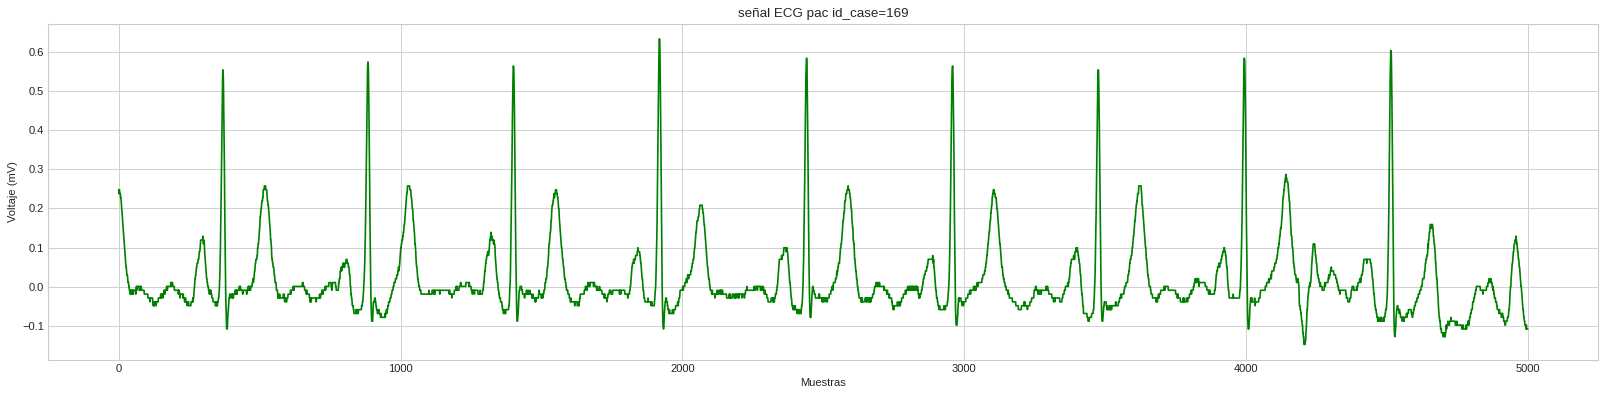

In [ ]:
plt.figure(figsize=(25,12),dpi=80)
plt.subplot(2,1,1)
plt.plot(s[290000:295000],'g')
plt.ylabel('Voltaje (mV)')
plt.xlabel('Muestras')
plt.title('señal ECG pac id_case=169')

###**Usando la información clinica para saber en que minuto se comienza cada estado de anestesia:**
1. Paciente esta siendo inducido a la anestesia
2. Paciente completamente anestesiado
3. Fin de la anestesia y el paciente comienza a despertar

In [ ]:
a=df_cases.loc[df_cases['caseid']==173]
inicio_anes=int(((a['anestart'])*-1)/60)
fin_ans=int((a['aneend'])/60)
fin_case=int((a['caseend'])/60)

print(f'Inicio anestesia, minuto: {inicio_anes}')
print(f'Final anestesia, minuto: {fin_ans}')
print(f'Pesona_despierta,termina la grabacion, minuto: {fin_case}')
a

Inicio anestesia, minuto: 12
Final anestesia, minuto: 92
Pesona_despierta,termina la grabacion, minuto: 98


,caseid,subjectid,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,...,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
172,173,1630,0,5938,-748,5552.0,1052,4952,-218820,472380,...,0,100,0.0,100,50,0,0,0,0,0


###**Creando un DataFrame con el tiempo y las señales**
* Se dejó la Fs=500 Hz original de la señal ECG
* Se dejó la Fs=1s (es su F s original) para la señal Bis


In [ ]:
def signall(Fsc,Fsb,t1,t2,df):
  trks_knn=[]
  dfc= pd.DataFrame()
  dfb= pd.DataFrame()
  time_C=np.arange(t1,t2, 1/Fsc)
  time_B=np.arange(t1,t2, 1/Fsb)
  dfc["tiempo"] = time_C
  dfb["tiempo"] = time_B
  for i in range(0,len(df),1):
    ecg=pd.DataFrame(df.iloc[i][0])
    ecg=ecg[(t1*Fsc)-1:(t2*Fsc)-1]
    ecg2=ecg.to_numpy().transpose().tolist()
    ecg2=ecg2[0]
    # ecg=ecg.transpose()
    bis=pd.DataFrame(df.iloc[i][1])
    bis=bis[(t1*Fsb)-1:(t2*Fsb)-1]
    bis2=bis.to_numpy().transpose().tolist()
    bis2=bis2[0]
    # bis=bis.transpose()
    c=(df.iloc[i][2]).tolist()
    dfc[f"ecg_{c}"] = ecg2
    dfb[f"bis_{c}"] = bis2
  return dfc,dfb,time_C,time_B

**El tiempo de grabacion durante toda la cirugia es demasiado, por eso se elige 10 minutos para cada estado de la anestesia**

In [ ]:
Fsc=500
Fsb=1

# 10 minutos de la señal cuando se esta induciendo la anestesia
t1=12*60    #12 a 21
t2=21*60 #26
(dfc1,dfb1,time_C1,time_B1)=signall(Fsc,Fsb,t1,t2,df)

#10 minutos de la señal cuando el paciente esta totalmente anestesiado
t1=40*60
t2=49*60 #26
(dfc2,dfb2,time_C2,time_B2)=signall(Fsc,Fsb,t1,t2,df)

#10 minutos de la señal cuando es el final de la anestesia y el paciente empieza a despertar
t1=78*60
t2=87*60 #26
(dfc3,dfb3,time_C3,time_B3)=signall(Fsc,Fsb,t1,t2,df)




#**PREPARACION DE LOS DATOS**

###**Imputando los datos del DataFrame**

1. **Forward Filling:** Metodo de imputación que utiliza los valores anteriores al valor faltante, se le conoce como propagación hacia adelante (forward filling). Esta técnica implica copiar el último valor válido hacia adelante para llenar los valores faltantes.

Al utilizar la propagación hacia adelante, es importante tener en

---

cuenta que esta técnica asume que los valores anteriores son representativos y siguen siendo válidos para los valores faltantes posteriores. Si la señal ECG tiene cambios rápidos o patrones complejos, la propagación hacia adelante puede no ser la mejor opción, ya que los valores imputados pueden no reflejar con precisión la verdadera variabilidad de la señal.


In [ ]:
# Aplico el mpetodo de imputación a los 3 segmentos de la señal
ecg_filled_1=dfc1.fillna(method='ffill')
ecg_filled_2=dfc2.fillna(method='ffill')
ecg_filled_3=dfc3.fillna(method='ffill')

**Graficando los segmentos de señal**

1. Segmento 1 (inducción a la anestesia)

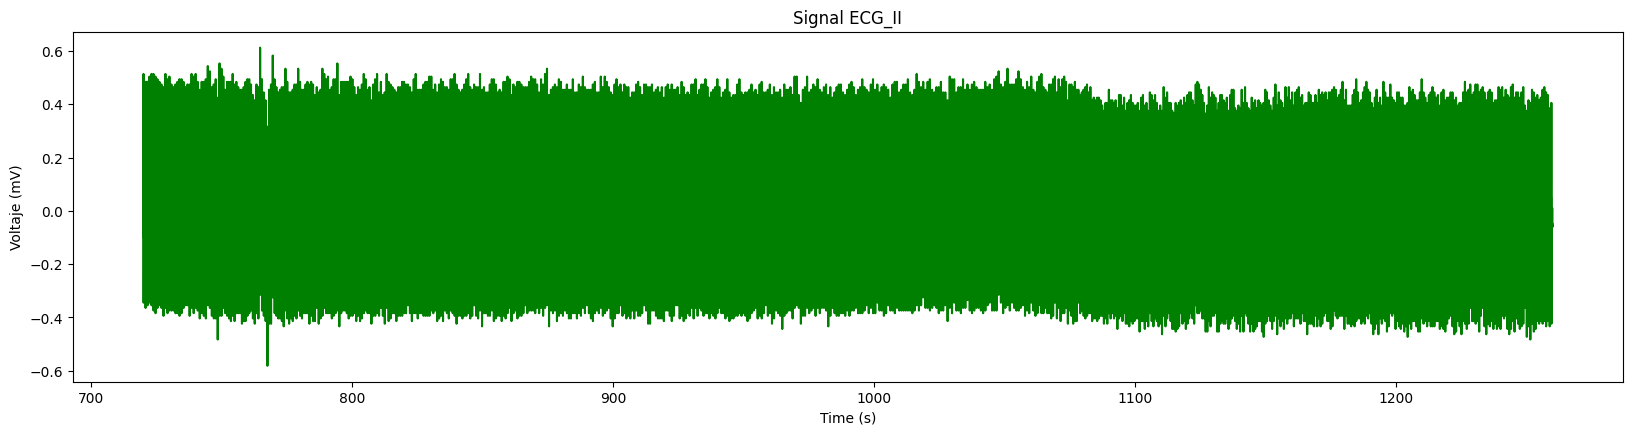

In [ ]:
ecg_1=np.asarray(ecg_filled_1['ecg_173'].to_numpy().transpose().tolist())  #205 #208
ecg_1_t=np.asarray(ecg_filled_1['tiempo'].to_numpy().transpose().tolist())
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(ecg_1_t,ecg_1,color='g')  # comienza desde 1200 seg --> 50000*0.002 + 1200=Tiempo_real
plt.xlabel("Time (s)")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II")
print("")
#plt.xlim([1400,1450])

2. Segmento 2  (Anestesiado)

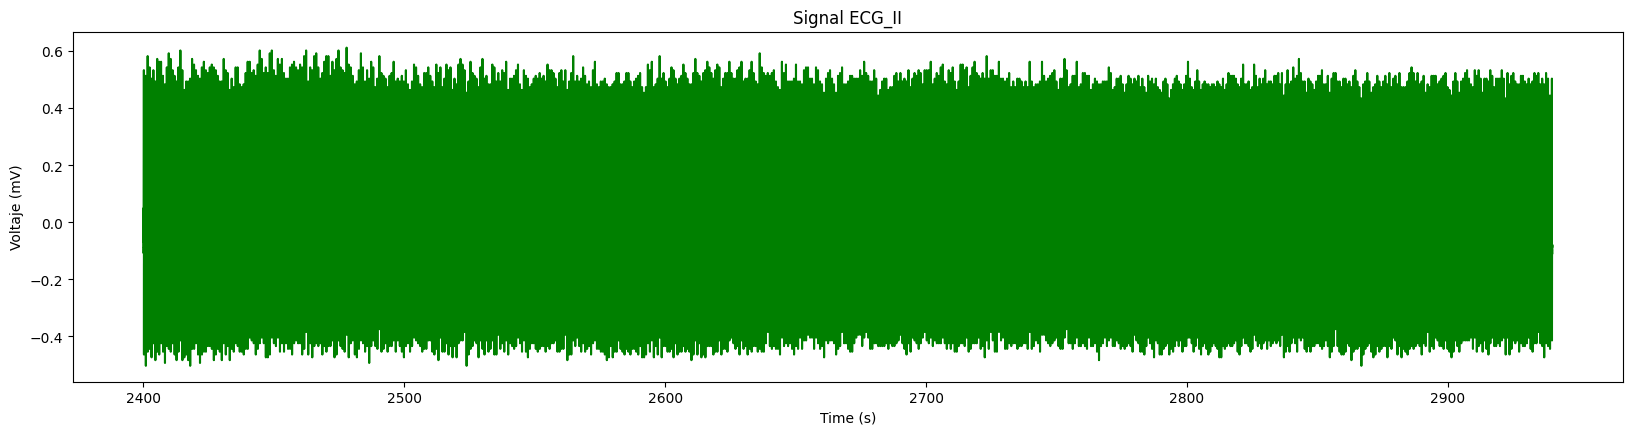

In [ ]:
ecg_2=np.asarray(ecg_filled_2['ecg_173'].to_numpy().transpose().tolist())  #205 #208
ecg_2_t=np.asarray(ecg_filled_2['tiempo'].to_numpy().transpose().tolist())
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(ecg_2_t,ecg_2,color='g')  # comienza desde 1200 seg --> 50000*0.002 + 1200=Tiempo_real
plt.xlabel("Time (s)")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II")
print("")
#plt.xlim([1400,1450])


3. Segmento 3  (Paciente despertando)

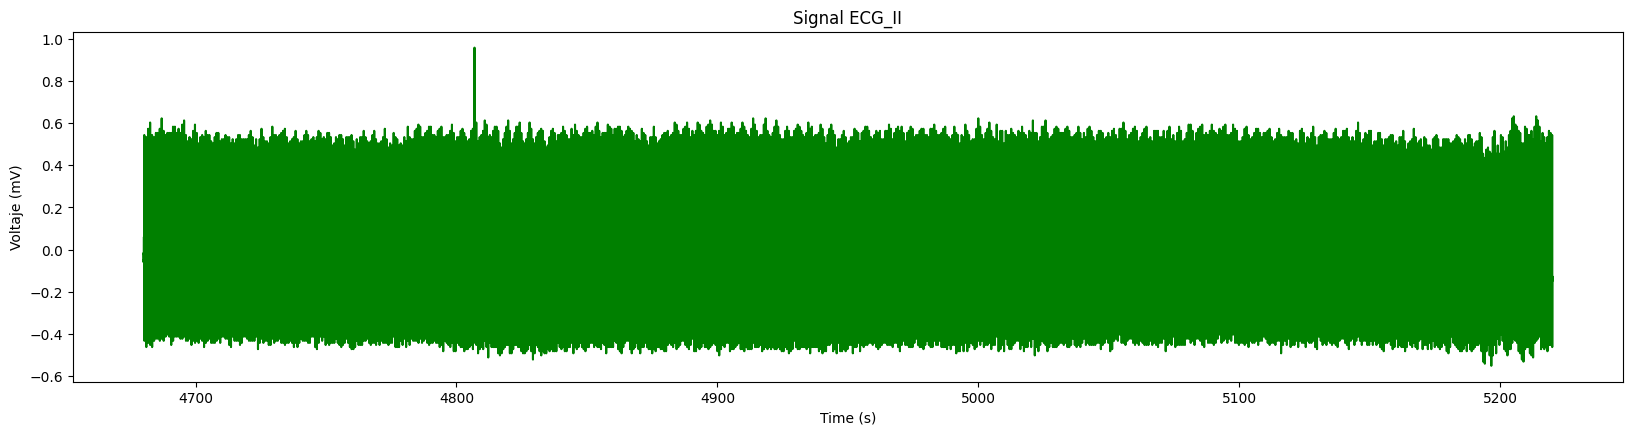

In [ ]:
ecg_3=np.asarray(ecg_filled_3['ecg_173'].to_numpy().transpose().tolist())  #205 #208
ecg_3_t=np.asarray(ecg_filled_3['tiempo'].to_numpy().transpose().tolist())
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(ecg_3_t,ecg_3,color='g')  # comienza desde 1200 seg --> 50000*0.002 + 1200=Tiempo_real
plt.xlabel("Time (s)")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II")
print("")
#plt.xlim([1400,1450])


###**Transformada Wavelet Para suavizar la señal**

In [ ]:
!pip install PyWavelets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importo las librerias
import pywt
import pywt.data
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Para ver que familias y tipos de transformadas wavelets existen.
pywt.families(short=True)
#pywt.families(short=False)
pywt.wavelist('bior')
w = pywt.Wavelet('sym11')
print(w)
w.dec_len
pywt.wavelist(kind='discrete')

###Eligiendo la mejor wavelet madre

Teoria
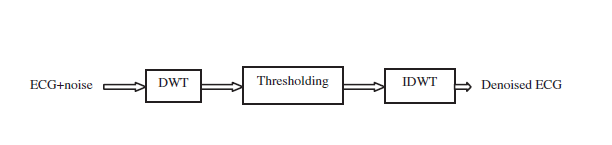

1. Descomponer la señal (coeficientes)
* Tener en cuenta el maximo nivel válido usado en la descomposición. Para elegir un nivel diferente al máximo se hace la resta nivel máximo-sub_coeff_of_decomp.  
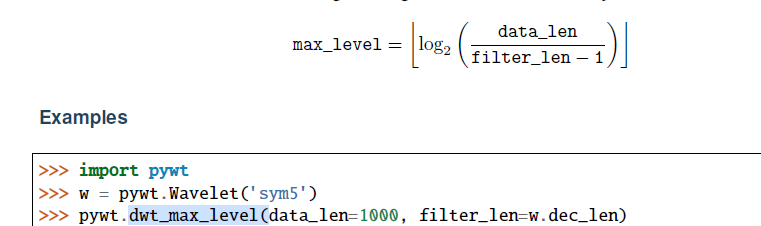

2. Thresholding
* Elijo un umbral para hacer el filtro 'soft'. Para elegir el umbral existen varios métodos, utilizo el método SureShrink

3. Reconstruyo la señal Wavelet
4. Grafico un tramo de la señal Filtrada Vs la original

El Codigo analiza varias wavelets madre y varios niveles para determinar cual es el mejor. La decisión la toma a partir del SNR mas alto y el RMSE  más bajo. La función tiene anidado otras funciones que se deben correr primero. La señal de entrada ecg_signal se pasa como un array.

In [ ]:
import pywt
import pywt.data
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
def choose_wavelet(ecg_signal):
    sub_dec_levels = [1,2,3]# Lista de descomposición de niveles
    wavelets = pywt.wavelist(kind='discrete') #Lista de todas la familia de wavelets discretas
    # Inicializo 4 listas para el SNR, RMSE, las wavelets y los niveles
    RMSE_list, SNR_list, wavelet_type_list, dec_lvl_list = [], [], [], []
    # Guardo la señal con ruido en una lista y en otra lista también guardo el indice asociado a cada dato
    index = []
    data = []
    for i in range (len(ecg_signal)):
        X = float(i)
        Y = float(ecg_signal[i])
        index.append(X)
        data.append(Y)
    # Creo un dos for, anidados uno para los niveles y otro para los diferentes tipos de wavelts
    for level in sub_dec_levels:
      for wavelet in wavelets:
        wavelet_type = wavelet
        w = pywt.Wavelet(wavelet_type)
        l=pywt.dwt_max_level(len(data), w.dec_len)  # de acuerdo a la señal calcula cuanto sería el nivel máximo aceptado
        maxlev = l - level
        coeffs = pywt.wavedec(data, wavelet_type, level=maxlev) # Descomposición wavelet de la señal con los coeficientes
        decision_type='soft'  # Defino que se un filtro suave, tambies se puede la opción 'hard'
        for i in range(1, len(coeffs)):
          M = len(coeffs[i])
          lambda_val = math.sqrt(2*math.log(M)) # Umbral para filtrar, Metodo SureShrink
          coeffs[i] = pywt.threshold(coeffs[i], lambda_val, decision_type) # Filtar el ruido una desicion de filtro 'soft'
        datarec = pywt.waverec(coeffs, wavelet_type) # Reconstruccion wavelet de la señal
        # Calculo el RMSE
        RMSE = round(math.sqrt(mean_squared_error(data, datarec)), 4)
        # Calculo el SNR
        orig_sum_square = sum(i*i for i in data)
        pred_mins_orig = sum((y-x)**2 for x,y in zip(datarec, data))
        SNR=10*math.log10(orig_sum_square/pred_mins_orig)
        SNR = round(SNR, 4)
        # Creo listas con los valores de los errores
        RMSE_list.append(RMSE)
        SNR_list.append(SNR)
        wavelet_type_list.append(wavelet_type)
        dec_lvl_list.append(maxlev)
    # Encuentro el valor minimo en RMSE y el valor max en SNR
    min_val_RMSE = min(RMSE_list, key=abs)
    max_val_SNR = max(SNR_list, key=abs)
    min_RMSE_index = RMSE_list.index(min_val_RMSE)
    max_SNR_index = SNR_list.index(max_val_SNR)
    # Imprimo la mejor wavelet
    print(f"Min value found for RMSE: {min_val_RMSE}, wavelet type: {wavelet_type_list[min_RMSE_index]}, decomposition_level: {dec_lvl_list[min_RMSE_index]}")
    #print(f"Max value found for SNR: {max_val_SNR}, wavelet type: {wavelet_type_list[max_SNR_index]}, decomposition_level: {dec_lvl_list[max_SNR_index]}")
choose_wavelet(ecg_1)

Min value found for RMSE: 0.117, wavelet type: bior3.3, decomposition_level: 13


###**Aplicando la wavelet madre**

In [ ]:
# Despues de saber la wavelet y el nivel adecuado, se utiliza esta funcion para aplicarlo a la señal y ver la grafica
def denoise_ecg_signal(ecg,wavelet_type, nivel,ecg_35_t):
    index = []
    data = []
    for i in range (len(ecg)):
        X = float(i)
        Y = float(ecg[i])
        index.append(X)
        data.append(Y)
    w = pywt.Wavelet(wavelet_type)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len) - nivel # Maximo nivel usado para la descomposición
    coeffs = pywt.wavedec(data, wavelet_type, level=maxlev) # Descomposición wavelet de la señal con los coeficientes

    for i in range(1, len(coeffs)):
      M = len(coeffs[i])
      lambda_val = math.sqrt(2*math.log(M)) # Umbral para filtrar, Metodo SureShrink
      coeffs[i] = pywt.threshold(coeffs[i], lambda_val, 'soft') # Filtar el ruido una desicion de filtro 'soft'
    datarec = pywt.waverec(coeffs, wavelet_type) # Reconstruccion wavelet de la señal

    # Definiendo un tramo para graficar mas de cerca y ver mejor el ruido filtrado
    min_sample = 0
    max_sample = 5000 # puedes cambiarlo a otro numero

    # Grafica la señal original y la filtrada
    plt.figure(figsize=(20, 10), dpi=80)
    plt.subplot(3, 1, 1)
    plt.plot(ecg_35_t[min_sample:max_sample], data[min_sample:max_sample])
    plt.legend(fontsize=30)
    plt.xlabel('Muestras')
    plt.ylabel('Voltaje')
    plt.title("Raw signal", fontsize=18)
    plt.subplot(3, 1, 2)
    plt.plot(ecg_35_t[min_sample:max_sample], datarec[min_sample:max_sample])
    plt.xlabel('sample')
    plt.ylabel('Muestras')
    plt.title(f"De-noised signal, dec_lvl = {maxlev}, wavelet type = {wavelet_type}", fontsize=18)
    plt.tight_layout()


    # Grafica la señal original y la filtrada de manera que esten superpuestas
    RMSE = round(math.sqrt(mean_squared_error(data, datarec)), 4)
    orig_sum_square = sum(i*i for i in data)
    pred_mins_orig = sum((y-x)**2 for x,y in zip(datarec, data))
    SNR=10*math.log10(orig_sum_square/pred_mins_orig)
    SNR = round(SNR, 4)

    #plt.figure(figsize=(20, 10), dpi=80)
    plt.subplot(3, 1, 3)
    plt.plot(ecg_35_t[min_sample:max_sample], datarec[min_sample:max_sample], label=f"Denoised signal", color="red")
    plt.xlabel('Muestras')
    plt.ylabel('amplitude [mV]')
    plt.plot(ecg_35_t[min_sample:max_sample], data[min_sample:max_sample], label=f"Original filtered signal")
    plt.title(f"Clean and denoised signal, RMSE = {RMSE}, SNR = {SNR}\n wavelet type = {wavelet_type}, level of decomposition = {maxlev}", fontsize=16)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return datarec



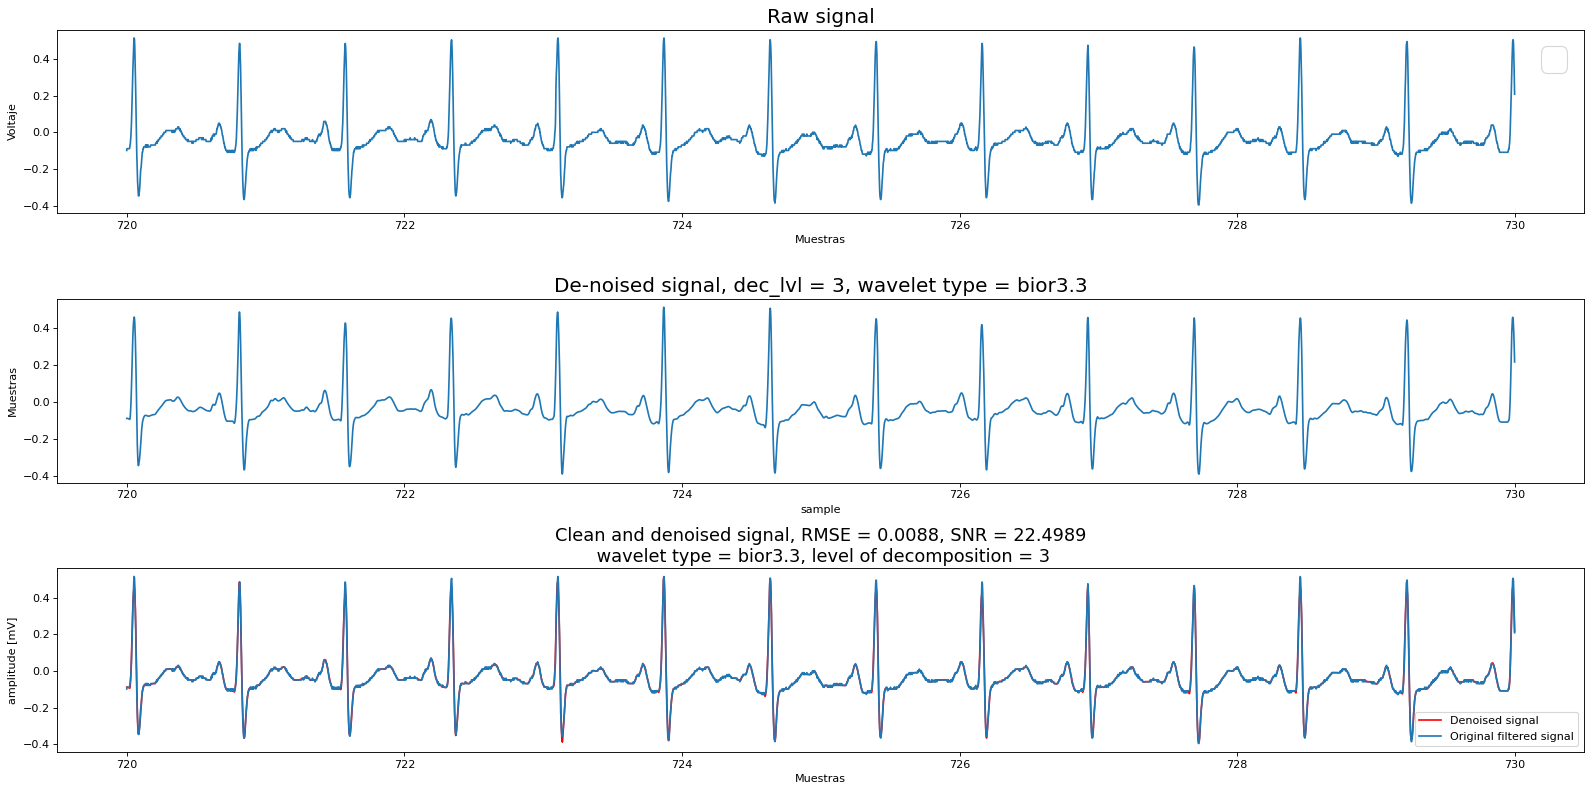

In [ ]:
datarec1=denoise_ecg_signal(ecg_1,'bior3.3', 12,ecg_1_t)

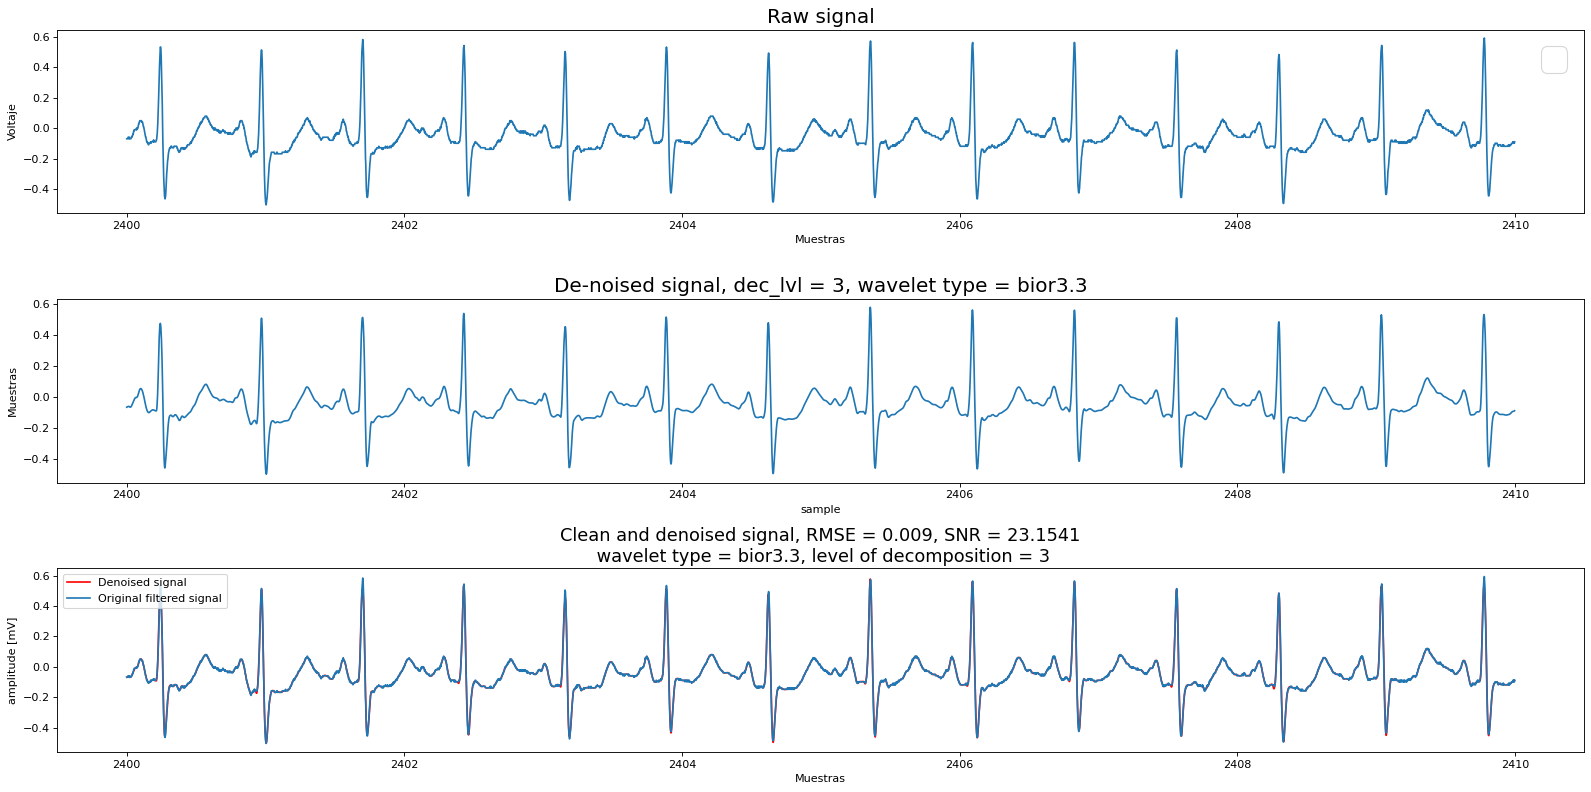

In [ ]:
datarec2=denoise_ecg_signal(ecg_2,'bior3.3', 12,ecg_2_t)

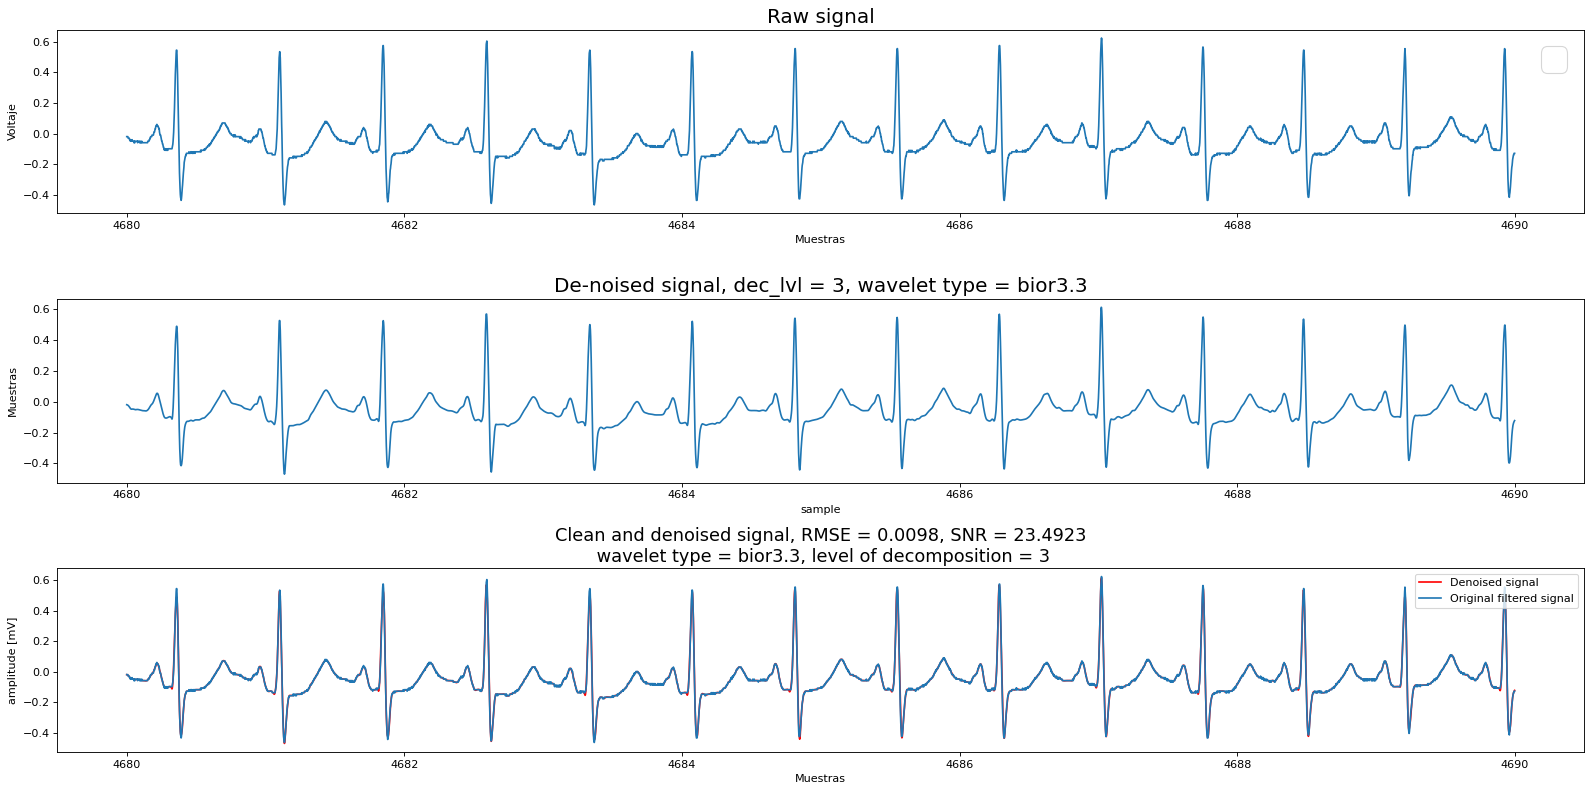

In [ ]:
datarec3=denoise_ecg_signal(ecg_3,'bior3.3', 12,ecg_3_t)

###**Centrar la señal en cero**

In [ ]:
def centrar(ecg,Fs,tiempo_ventana):
  Fs = int(Fs)
  tiempo_ventana = int(tiempo_ventana)
  tiempo = tiempo_ventana
  muestras = Fs*tiempo_ventana
  num_vent = int(len(ecg)/muestras)

  signal_correction = np.zeros(len(ecg)) # creo una matriz de ceros

  for i in range(num_vent):
    x = ecg[muestras*i:(muestras*i)+(muestras-1)]
    x = x - np.mean(x)
    signal_correction[muestras*i:(muestras*i)+(muestras-1)] = x

    if i==(num_vent-1) and (num_vent*muestras)<len(ecg):
            x = ecg[muestras*(i+1):(len(ecg)-1)]
            x = x - np.mean(x)
            signal_correction[muestras*(i+1):(len(ecg)-1)] = x

    return signal_correction


In [ ]:
signal_correction_1=centrar(datarec1,500,300)
signal_correction_1

In [ ]:
signal_correction_2=centrar(datarec2,500,300)
signal_correction_2

In [ ]:
signal_correction_3=centrar(datarec3,500,300)
signal_correction_3

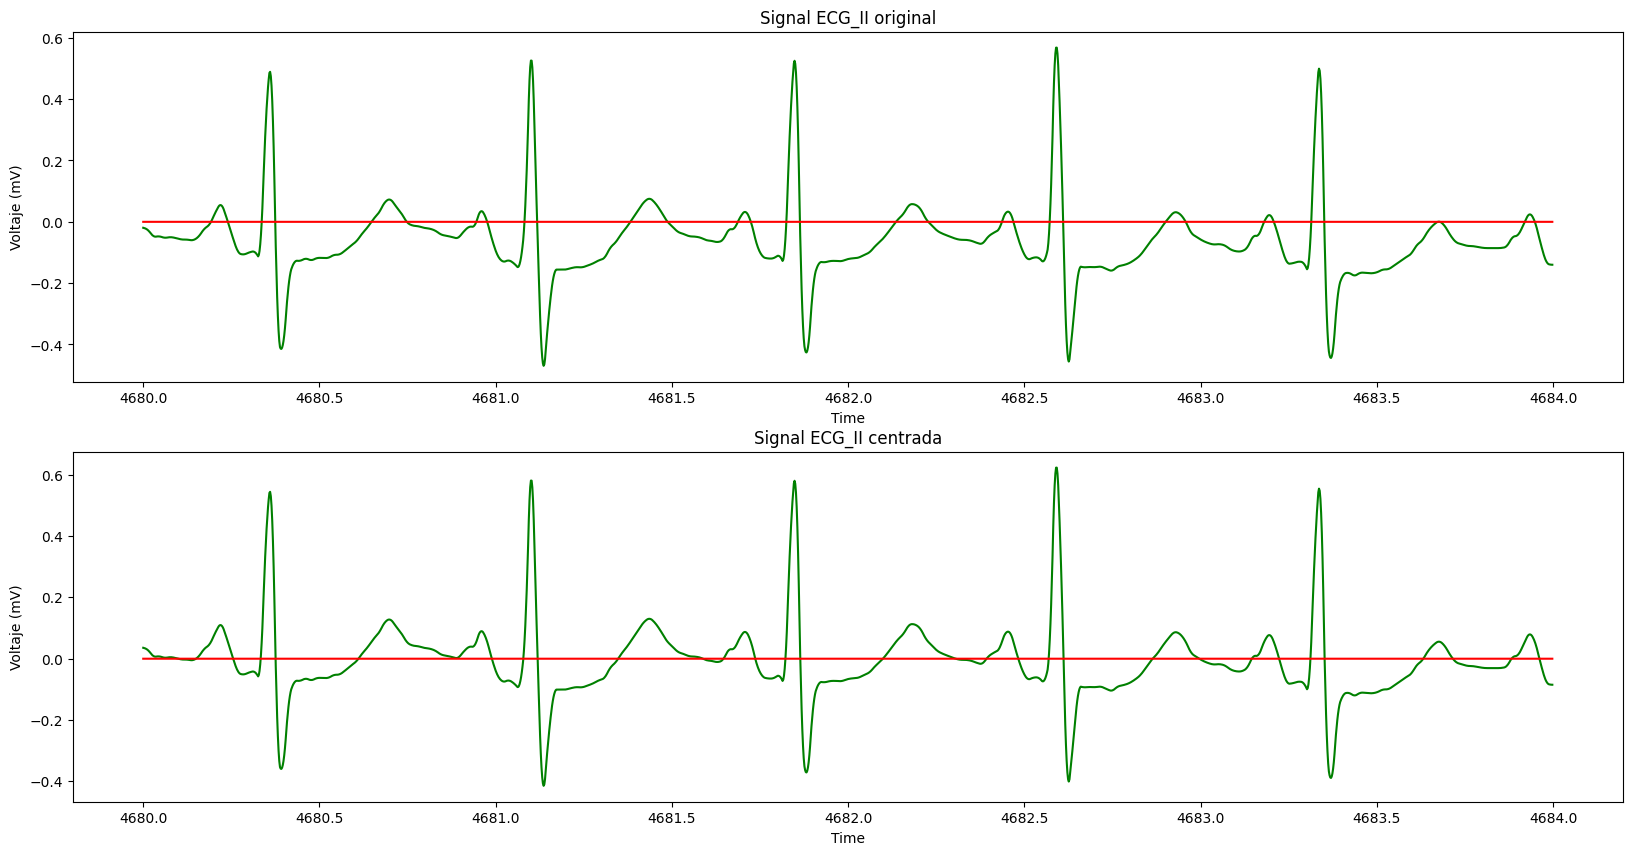

In [ ]:
signal_correction=signal_correction_3
datarec=datarec3
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
b=len(datarec)
plt.plot(ecg_3_t[0:2000],datarec[0:2000],color='g')
b=np.zeros(b)
plt.plot(ecg_3_t[0:2000],b[0:2000],color='r')
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II original")
print("")

plt.subplot(2,1,2)
plt.plot(ecg_3_t[0:2000],signal_correction[0:2000],color='g')
plt.plot(ecg_3_t[0:2000],b[0:2000],color='r')
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II centrada")
print("")
plt.show()


###**Remove linebase drift**

In [ ]:
import neurokit2 as nk
from scipy import signal
from scipy.signal import firwin, lfilter

In [ ]:
#El argumento cutoff hace referencia a la frecuencia menor que se va a eliminar, se recomienda que este valor sea menor a 1.
def low_pass_filter(ecg, cutoff):
    [a,b] = signal.butter(4,cutoff/100,'high');
    filtered_signal= signal.filtfilt(a,b,ecg)
    return filtered_signal
#END FUNCTION

In [ ]:
data_sin_bs_1=low_pass_filter(signal_correction_1,0.2)
data_sin_bs_2=low_pass_filter(signal_correction_2,0.2)
data_sin_bs_3=low_pass_filter(signal_correction_3,0.2)

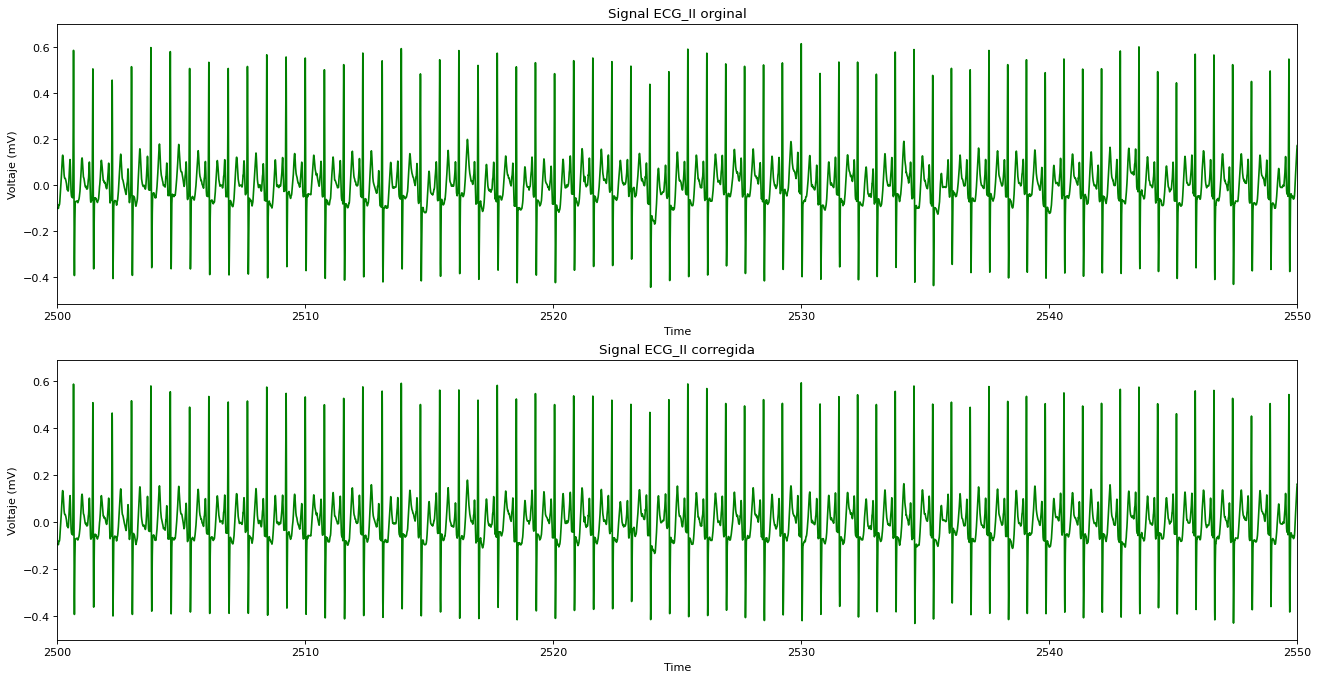

In [ ]:
plt.figure(figsize=(20,10), dpi=80)
plt.subplot(2,1,1)
a=0
b=len(datarec2)
plt.plot(ecg_2_t,signal_correction_2[a:b],color='g')
#plt.plot(ecg_35_t,b,'r')
b=np.zeros(b)
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II orginal")
print("")
plt.xlim([2500,2550])
plt.subplot(2,1,2)
plt.plot(ecg_2_t,data_sin_bs_2,color='g')
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Signal ECG_II corregida")
plt.xlim([2500,2550])
print("")
plt.show()

#**Extracción del HRV a aprtir de la señal ECG  sin ruido**

La idea es determinar la profundidad de la anestesia a partir de un parámetros derivado de la señal ECG  denominado HRV

In [ ]:
def hrv(ecg_sin_out,tiempo,Fs,correct_artifacts=True):
  peaks, info = nk.ecg_peaks(ecg_sin_out, sampling_rate=Fs, correct_artifacts=True)
  a=info['ECG_R_Peaks']
  pk_rs=ecg_1_t[a]
  rr=np.diff(pk_rs)
  return rr,info,a

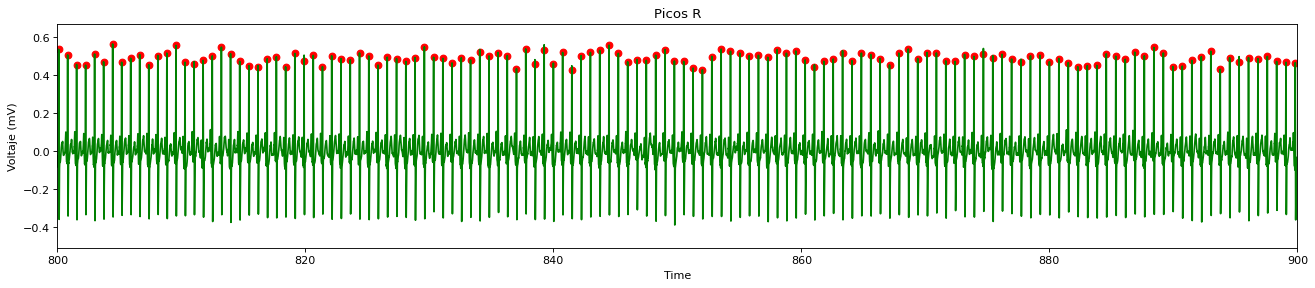

In [ ]:
rr_0,info1,a=hrv(data_sin_bs_1,ecg_1_t,500)
plt.figure(figsize=(20,8),dpi=80)
plt.subplot(211)
plt.plot(ecg_1_t,data_sin_bs_1,color='g')
plt.xlim([800,900])
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Picos R")
plt.scatter(ecg_1_t[a],data_sin_bs_1[a],color='r')

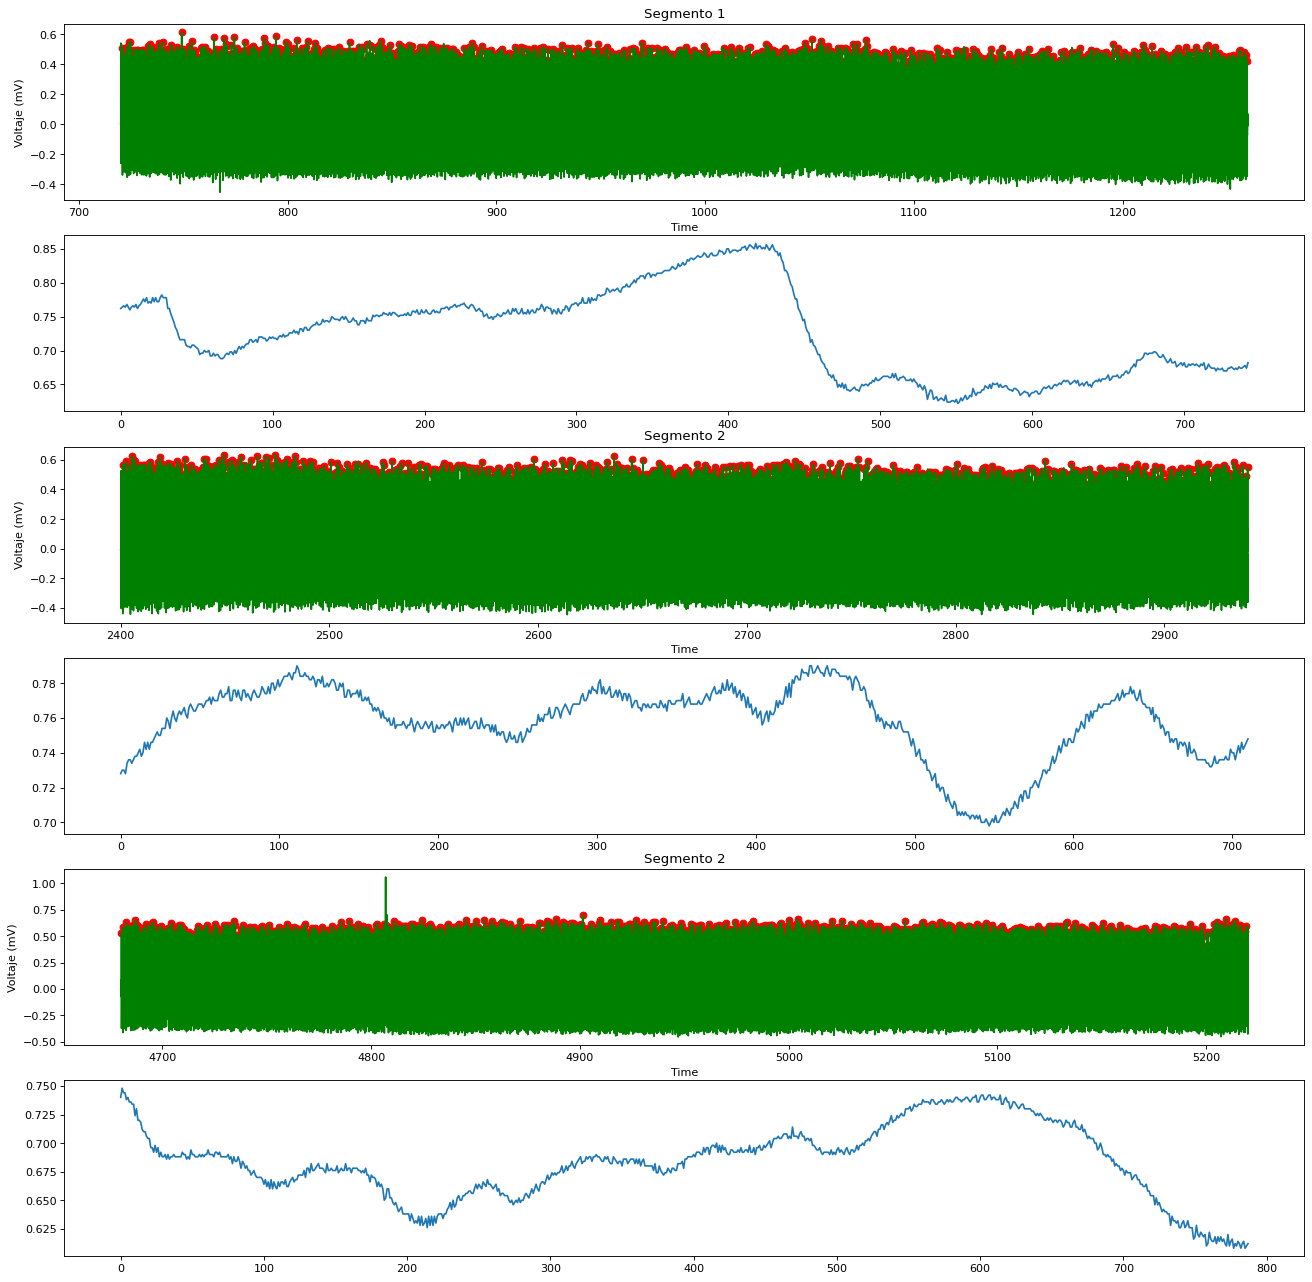

In [ ]:
rr_0,info1,a=hrv(data_sin_bs_1,ecg_1_t,500)
plt.figure(figsize=(20,20), dpi=80)
plt.subplot(611)
plt.plot(ecg_1_t,data_sin_bs_1,color='g')
#plt.xlim([800,900])
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Segmento 1")
plt.scatter(ecg_1_t[a],data_sin_bs_1[a],color='r')
plt.subplot(612)
plt.plot(rr_0,'-')
print("")
rr_1,info2,a=hrv(data_sin_bs_2,ecg_2_t,500)
plt.subplot(613)
plt.plot(ecg_2_t,data_sin_bs_2,color='g')
#plt.xlim([800,900])
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Segmento 2")
plt.scatter(ecg_2_t[a],data_sin_bs_2[a],color='r')
plt.subplot(614)
plt.plot(rr_1,'-')
print("")
rr_2,info3,a=hrv(data_sin_bs_3,ecg_3_t,500)
plt.subplot(615)
plt.plot(ecg_3_t,data_sin_bs_3,color='g')
#plt.xlim([2500,2550])
plt.xlabel("Time")
plt.ylabel("Voltaje (mV)")
plt.title("Segmento 2")
plt.scatter(ecg_3_t[a],data_sin_bs_3[a],color='r')
plt.subplot(616)
plt.plot(rr_2,'-')
plt.show()

En la señal ECG no se trataron los outliers porque esto puede afectar el calculo del HRV, entonces si el Hrv tiene outliers y picos ectopicos se corrigen, esto se hace para los tres segmentos.

In [ ]:
!pip install hrv-analysis
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_nn_intervals

In [ ]:
def denoising_hrv(r_i):
  rr = remove_outliers(rr_intervals=r_i*1000, low_rri=300, high_rri=2000)
  rr = interpolate_nan_values(rr_intervals=rr, interpolation_method="linear")
  rr = remove_ectopic_beats(rr_intervals=rr, method="karlsson")
  r = interpolate_nan_values(rr_intervals=rr)
  return r
rr_a=denoising_hrv(rr_0)
rr_b=denoising_hrv(rr_1)
rr_c=denoising_hrv(rr_2)
r_final=rr_a+rr_b+rr_c

In [ ]:
a=info1['ECG_R_Peaks'].tolist()
b=info2['ECG_R_Peaks'].tolist()
c=info3['ECG_R_Peaks'].tolist()
pk_r=a+b+c

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(211)
plt.plot(rr_a,'-')
#plt.xlim([200,400])

##**PREGUNTAS**
1. Como cambia el hrv en los diferentes estados de anestesia
2. Caracteristicas en el dominio de la frecuencia permitendiferenciar bien los estados de anestesia?
3. metodo no lineal permie dierenciar en algo la profundidad de la anestesia?

## **EXTRACCION DE CARACTERISTICAS**

In [ ]:
!pip install hrv-analysis

In [ ]:
from hrvanalysis import get_time_domain_features
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values, get_nn_intervals
from hrvanalysis import get_time_domain_features, get_frequency_domain_features, get_geometrical_features
from hrvanalysis import get_poincare_plot_features, get_csi_cvi_features, get_sampen
from hrvanalysis import plot_psd, plot_distrib
from hrvanalysis import plot_poincare,plot_timeseries

####**1. Características en el dominio del tiempo**

In [ ]:
time_domain_features = get_time_domain_features(rr_a)

In [ ]:
time_domain_features

{'mean_nni': 725.1386271699322,
 'sdnn': 64.27787470734533,
 'sdsd': 4.017377123468119,
 'nni_50': 0,
 'pnni_50': 0.0,
 'nni_20': 0,
 'pnni_20': 0.0,
 'rmssd': 4.018823633286559,
 'median_nni': 729.9999999827378,
 'range_nni': 235.99999999441934,
 'cvsd': 0.005542145298439286,
 'cvnni': 0.08864218826434435,
 'mean_hr': 83.38698966569817,
 'max_hr': 96.46302251031963,
 'min_hr': 69.93006993172355,
 'std_hr': 7.298081593082684}

####**2. Características en el dominio de la frecuencia**

In [ ]:
from hrvanalysis import plot_psd, plot_distrib

In [ ]:
!pip install pyhrv
import pyhrv
import pyhrv.nonlinear as nl
import pyhrv.frequency_domain as fd

In [ ]:
segment=np.array([np.array(rr_a),np.array(rr_b),np.array(rr_c)])
segment

**Grafica de los tres segemento de la señal, cada curva son las frecuencias de cada segmento**

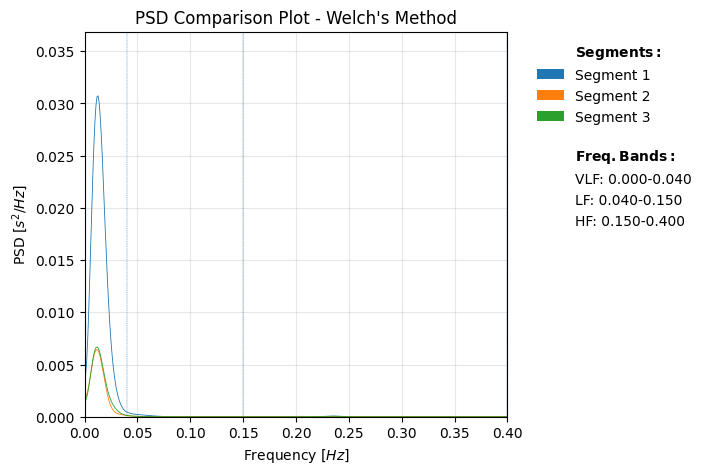

In [ ]:
a=fd.psd_comparison(nni=r_final, rpeaks=pk_r, segments=segment, method='welch', fbands=None, duration=1200, show=True,
                                      kwargs_method=None)

 Además, tres características del dominio de frecuencia de HRV, que incluyen la potencia de alta frecuencia (HF), la potencia de baja frecuencia (LF) la relación de potencia de alta a baja frecuencia (HF/LF).

 La HF durante el estado de inducción de la anestesia es significativamente mayor que la del estado de mantenimiento de la anestesia. La HF durante el estado de recuperación es significativamente mayor que la de los estados de mantenimiento anestésico  e inducción anestésica.

**Grafica para cuando el paciente esta siendo inducido a la anestesia**

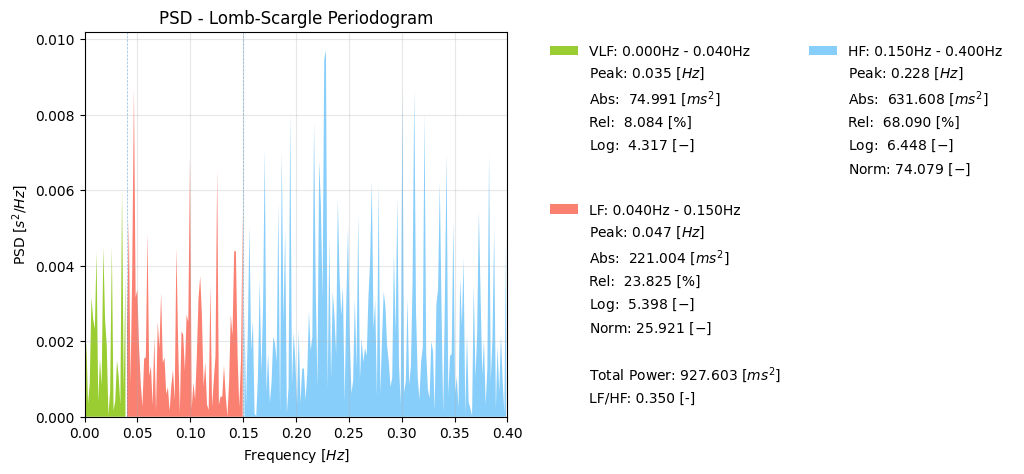

ReturnTuple(lomb_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), lomb_peak=(0.035372549019607846, 0.04662745098039216, 0.22831372549019607), lomb_abs=(74.99086696925079, 221.00398744914148, 631.6080115105485), lomb_rel=(8.084372065210445, 23.825280792747307, 68.09034714204225), lomb_log=(4.317366332377963, 5.39818074411128, 6.448268966769926), lomb_norm=(25.92081600057216, 74.07918399942784), lomb_ratio=0.3499068780343526, lomb_total=927.6028659289408, lomb_plot=<Figure size 1200x500 with 2 Axes>, lomb_nfft=256, lomb_ma=None)

In [ ]:
# Compute the PSD and frequency domain parameters using the R-peak series
fd.lomb_psd(rpeaks=ecg_1_t[info1['ECG_R_Peaks']])
#result=fd.welch_psd(nni=rr_a, rpeaks=None, fbands=None, nfft=2**12,
                                # detrend=True, window='hamming', show=False, show_param=True, legend=True);


**Paciente anestesiado**

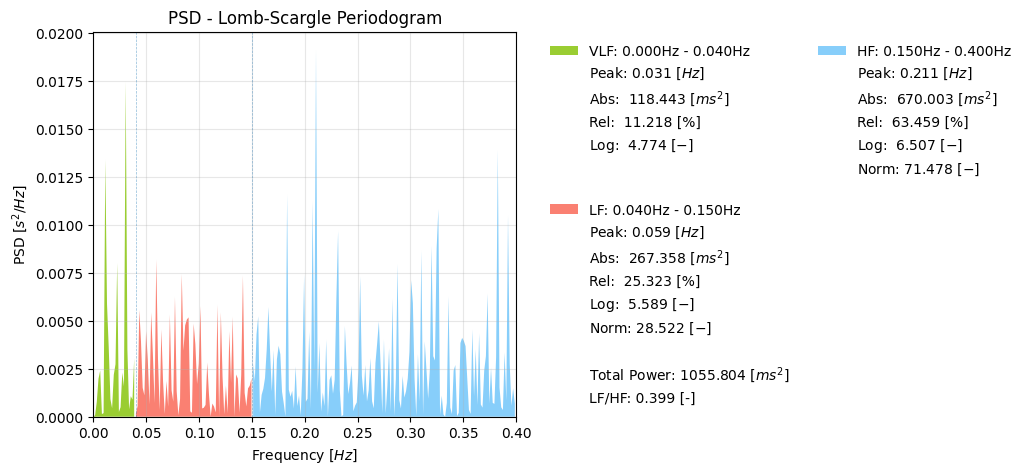

ReturnTuple(lomb_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), lomb_peak=(0.030549019607843137, 0.059490196078431375, 0.21062745098039215), lomb_abs=(118.44300593860005, 267.35820280834156, 670.0032272989755), lomb_rel=(11.218271291052705, 25.322701220087897, 63.4590274888594), lomb_log=(4.774431882332142, 5.588589342832949, 6.507282529237553), lomb_norm=(28.522424138758527, 71.47757586124148), lomb_ratio=0.39904017162149924, lomb_total=1055.804436045917, lomb_plot=<Figure size 1200x500 with 2 Axes>, lomb_nfft=256, lomb_ma=None)

In [ ]:
fd.lomb_psd(rpeaks=ecg_2_t[info2['ECG_R_Peaks']]) #show_param=False

**Paciente despertando**

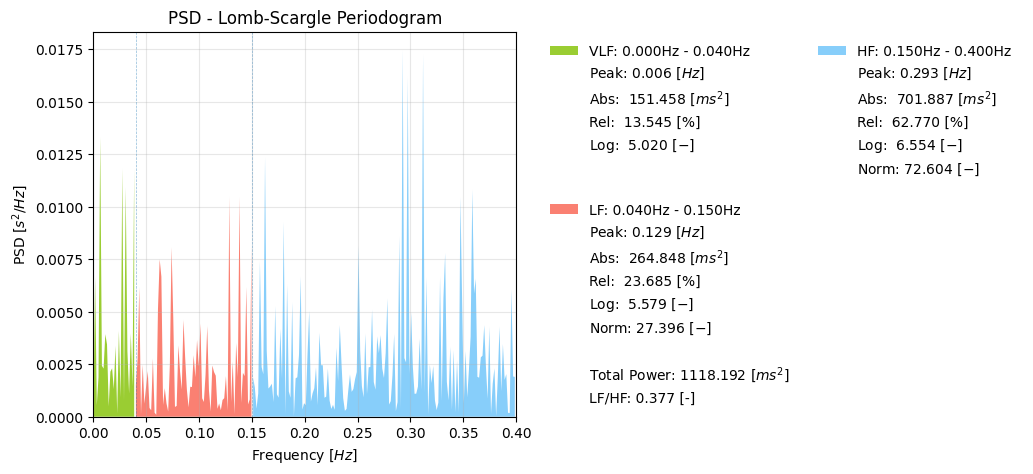

ReturnTuple(lomb_bands=ReturnTuple(ulf=None, vlf=(0.0, 0.04), lf=(0.04, 0.15), hf=(0.15, 0.4)), lomb_peak=(0.006431372549019608, 0.12862745098039216, 0.29262745098039217), lomb_abs=(151.45785379995027, 264.84791636758587, 701.8865968860646), lomb_rel=(13.544883533683622, 23.68536257007828, 62.7697538962381), lomb_log=(5.020307393507044, 5.57915576074262, 6.553771848079008), lomb_norm=(27.39613748517277, 72.60386251482723), lomb_ratio=0.3773371902848544, lomb_total=1118.1923670536007, lomb_plot=<Figure size 1200x500 with 2 Axes>, lomb_nfft=256, lomb_ma=None)

In [ ]:
fd.lomb_psd(rpeaks=ecg_3_t[info3['ECG_R_Peaks']])

####**Caracteristicas no lineales**

#####**Poncaire**
El diagrama de Poincaré es una representación geométrica que permite la identificación visual de la presencia de componentes HRV no lineales. 11 En los gráficos de Poincaré, el ancho SD1 refleja la actividad parasimpática; y la longitud SD2 refleja la modulación simpática.
La forma del diagrama de Poincaré se puede utilizar para evaluar visualmente la actividad simpatovagal. Una forma alargada, similar a un torpedo, con una relación SD1/SD2 reducida se asocia con un tono simpático elevado, y una configuración más ovalada en forma de abanico resultante de una relación SD1/SD2 aumentada indica un tono menos simpático. 2 , 13Los puntos se dispersan más cuando aumenta la actividad vagal o disminuye la actividad simpática. Cuando la anestesia se profundiza, la actividad autonómica disminuye, lo que da como resultado una disminución de SD1, SD2 y gráficos de Poincaré convergentes. Esta forma se puede ver en la condición de muerte cerebral en la que se pierde la actividad autónoma total.

**Inducción a la anestesia**

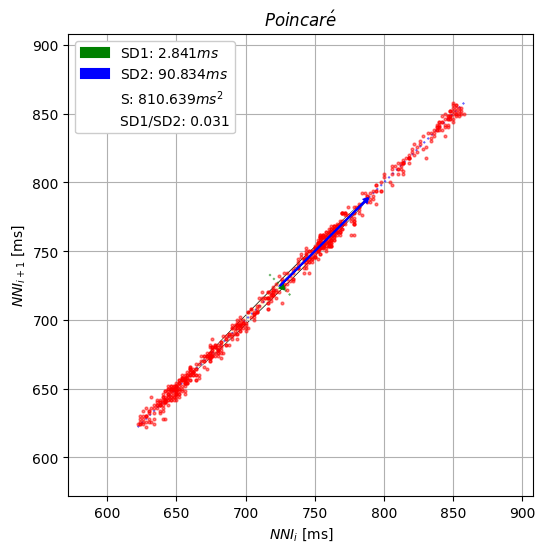

In [ ]:
# Compute Poincaré using NNI series
results=nl.poincare(rr_a)
# Print SD1

**Anestesiado**

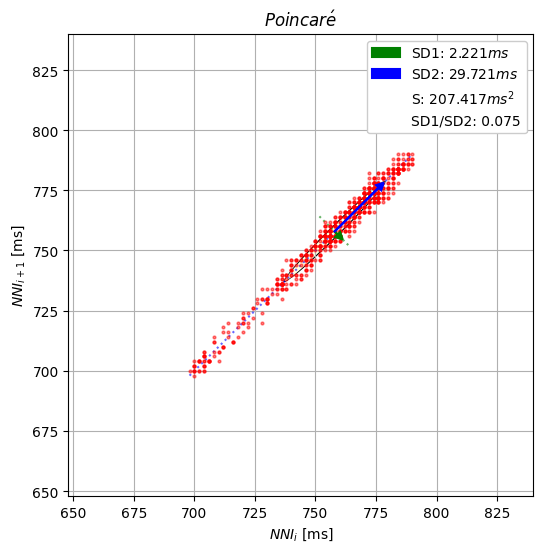

ReturnTuple(poincare_plot=<Figure size 600x600 with 1 Axes>, sd1=2.22144424208554, sd2=29.72076112909495, sd_ratio=13.379026385642007, ellipse_area=207.4174147469184)

In [ ]:
nl.poincare(rr_b)

**Despertando**

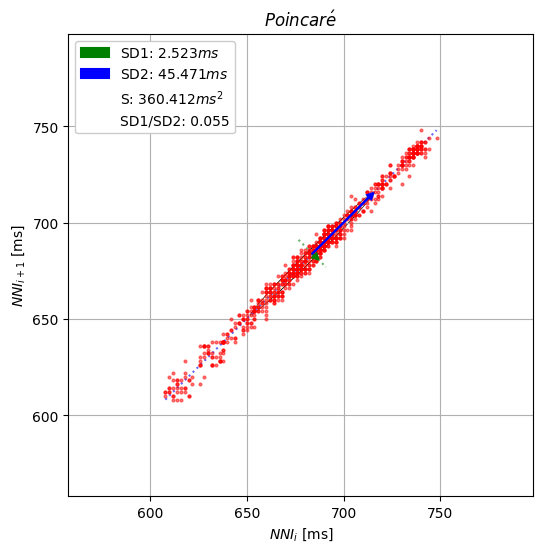

ReturnTuple(poincare_plot=<Figure size 600x600 with 1 Axes>, sd1=2.522979736053238, sd2=45.47107026137103, sd_ratio=18.02276475375208, ellipse_area=360.41164231968537)

In [ ]:
nl.poincare(rr_c)

#####**Entropia**

In [ ]:
entropia_1=nl.sample_entropy(rr_a,ecg_1_t[info1['ECG_R_Peaks']])
print(f'Entropia del segmento 1 (Induciendo la anestesia): {entropia_1}')
entropia_2=nl.sample_entropy(rr_b,ecg_2_t[info2['ECG_R_Peaks']])
print(f'Entropia del segmento 2 (Totalmente anstesiado): {entropia_2}')
entropia_3=nl.sample_entropy(rr_c,ecg_3_t[info1['ECG_R_Peaks']])
print(f'Entropia del segmento 3 (Fin de anestesia, paciente despertando): {entropia_3}')


Entropia del segmento 1 (Induciendo la anestesia): ReturnTuple(sampen=0.12165491387857492)
Entropia del segmento 2 (Totalmente anstesiado): ReturnTuple(sampen=0.3282469172911378)
Entropia del segmento 3 (Fin de anestesia, paciente despertando): ReturnTuple(sampen=0.1871341214488714)


**Análisis de fluctuación**

**Inducción a la anestesia**

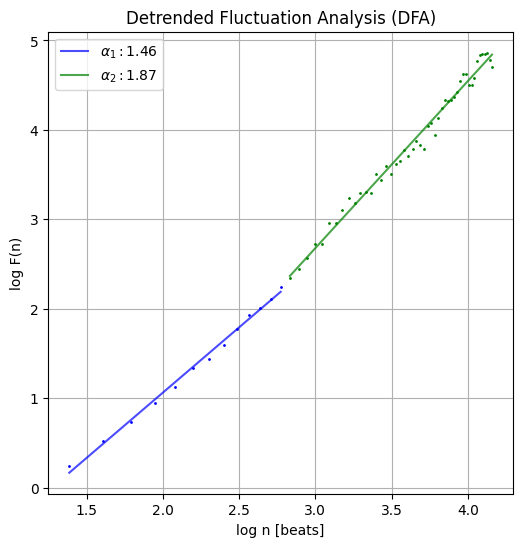

In [ ]:
results = nl.dfa(rr_a)

**Anestesiado**

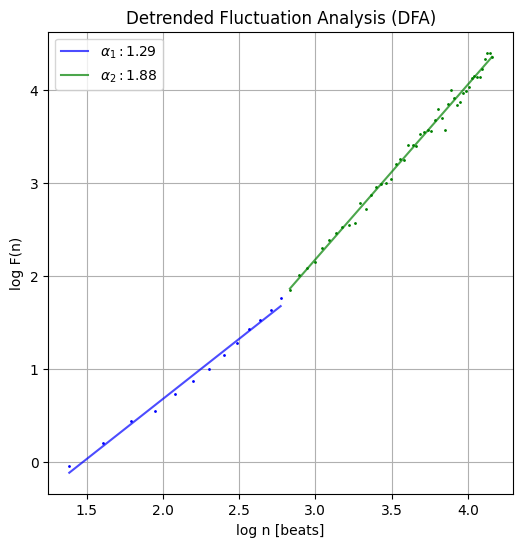

In [ ]:
results = nl.dfa(rr_b)

**Despertando**

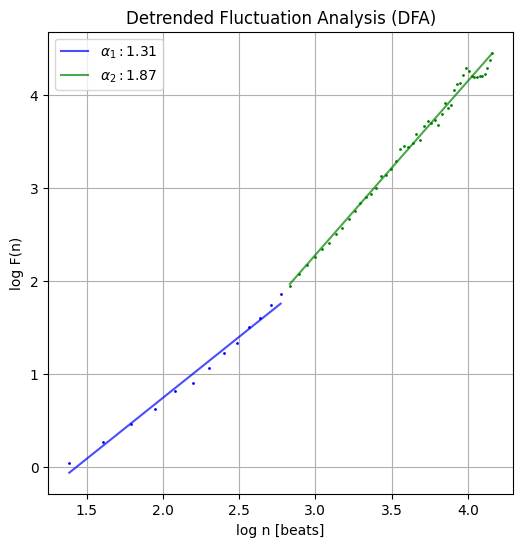

In [ ]:
results = nl.dfa(rr_c)

###**Parámetros geométricos en el dominio del tiempo**

1. TINN

In [ ]:
peaks, info = nk.ecg_peaks(data_sin_bs_1, sampling_rate=500, correct_artifacts=True)

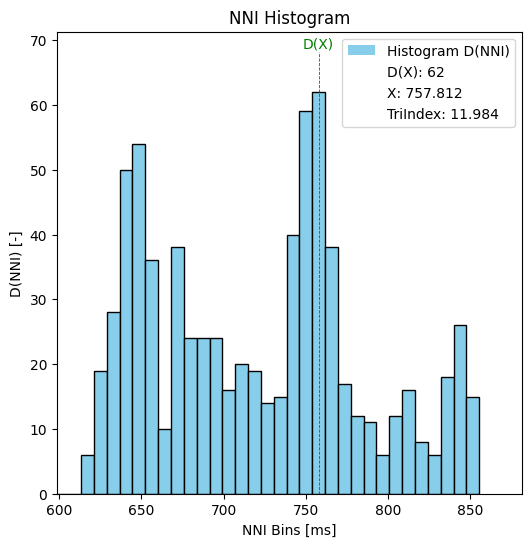

In [ ]:
import pyhrv.time_domain as td
results = td.triangular_index(rr_a)

/usr/local/lib/python3.10/dist-packages/pyhrv/time_domain.py:576: UserWarning: CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a malfunction of the function. This function will be reviewed over the next updates to solve this issue
  warnings.warn('CAUTION: The TINN computation is currently providing incorrect results in the most cases due to a '


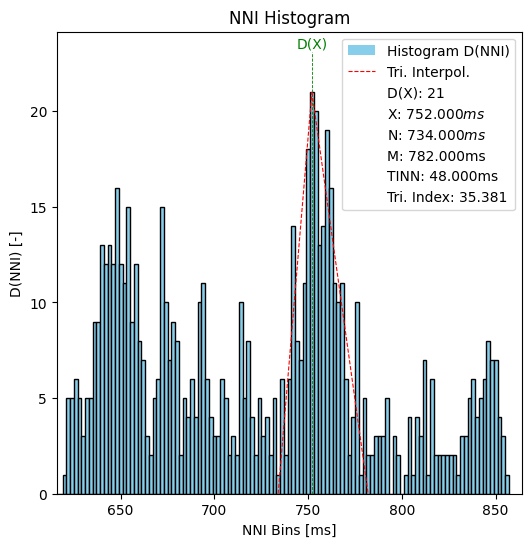

ReturnTuple(nni_histogram=<Figure size 600x600 with 1 Axes>, tinn_n=734.0, tinn_m=782.0, tinn=48.0, tri_index=35.38095238095238)

In [ ]:
pyhrv.time_domain.geometrical_parameters(nni=rr_a, rpeaks=(data_sin_bs_1[info['ECG_R_Peaks']])*1000,
                                         binsize=2, plot=True, show=True, figsize=None, legend=True)